## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
# import PyQt5 # Import this first in order to avoid picking up PyQt4
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        ret_calib, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        
        # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(1000)
#         cv2.imshow('img',dst)
#         cv2.waitKey(1000)
        
#         plt.imshow(dst, cmap='gray')
# plt.show()

# cv2.destroyAllWindows()

In [2]:
## Line Class

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Helper Functions

In [50]:
def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

def perspective_transform(image):
    offset = 100 # Revisit
    img_size = (image.shape[1], image.shape[0])
    
    # x and y co-ordinates
    src = np.float32([(589, 450), (200, 690), (1100, 690), (693, 450)])    
    dst = np.float32([(230 , 0), (230, 700), (1070, 700), (1070, 0)])    

    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
#     dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
#                                  [img_size[0]-offset, img_size[1]-offset], 
#                                  [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, img_size)
    return warped, Minv

def to_bin(image, thresh):
    binary = np.zeros_like(image)
    binary[(image >= thresh[0]) & (image <= thresh[1])] = 1.0
    return binary

def combine_bin(binary_images):
    binary = np.zeros_like(binary_images[0])
    for bin_image in binary_images:
        binary[(bin_image == 1)] = 1.0
    return binary

def abs_sobel_bin(image, orient='x', thresh=(50, 255), sobel_kernel=3):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return to_bin(scaled_sobel, thresh)

def abs_dir_bin(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    return to_bin(absgraddir, thresh)

def s(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    S = hls[:,:,2]
    return S

def l(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    L = hls[:,:,1]
    return L

def h(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)
    H = hsv[:,:,0]
    return H

def hls(image):
    hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    return hls_img[:,:,0], hls_img[:,:,1], hls_img[:,:,2]

def hsv(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)
    return hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]

def v(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)
    V = hsv[:,:,2]
    return V

def s_bin(image, thresh=(50, 255)):
    return to_bin(image, thresh)
    

# Line Finder

In [17]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def bound(curr_center, prev_center, window_width):
    if curr_center > prev_center and curr_center > prev_center + window_width:
        return prev_center + window_width
    if curr_center < prev_center and curr_center < prev_center - window_width:
        return prev_center - window_width
    
    return curr_center

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        # Don't let lcenter and rcenter go more than prev_center +/- window_width
        l_center = bound(l_center, window_centroids[-1][0], window_width)
        r_center = bound(r_center, window_centroids[-1][1], window_width)
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


def draw_line(warped, window_width = 50, window_height = 80, margin = 100):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output, window_centroids


## Pipeline Definition

In [51]:

#     abs_dir_img = abs_dir_bin(l_img, thresh=(75*0.0174533, 90*0.0174533))


def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
def gimshow(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    
def simshow(img):
    plt.imshow(img, cmap='gray')
    plt.show()    
    
def xor(img1, img2):
    xor_copy = np.copy(img1)
    xor_copy[ (img2 == 1) ] = 0
    return xor_copy

def and_img(img1, img2):
    and_copy = np.copy(img1)
    and_copy[ (img2 == 0) ] = 0
    return and_copy

def apply_sobel_xy(img, sobel_kernel_val=5):
    img_x = abs_sobel_bin(img, sobel_kernel=sobel_kernel_val, orient = 'x')
    img_y = abs_sobel_bin(img, sobel_kernel=sobel_kernel_val, orient = 'y')
    return combine_bin([img_x, img_y])
    
def pipeline(image):
    undist_image = undistort(image)
    transformed = undist_image#perspective_transform(undist_image)
    
    h_img, l_img, s_img = hls(transformed)
    s_bin_img = s_bin(s_img, (90, 255))
    
    h2_img, s2_img, v_img = hsv(transformed)
    
    l_img_sobel = apply_sobel_xy(l_img)
    s_img_sobel = apply_sobel_xy(s_img)
    
    s2_img_sobel = apply_sobel_xy(s2_img)
    v_img_sobel = apply_sobel_xy(v_img)
    
    combined_sobel = combine_bin([l_img_sobel, s_img_sobel, v_img_sobel, s2_img_sobel])

    combined = combine_bin([s_bin_img, combined_sobel])
    perspective_transformed, Minv = perspective_transform(image=combined)
#     return combined
#     return v_img_sobel
#     return combined_sobel
#     return and_img(combined, combined_sobel)
    window_width, window_height = 50, 80
    with_line, x_centers = draw_line(perspective_transformed, window_width, window_height)

    print(perspective_transformed.shape)
    max_y = perspective_transformed.shape[0]
    ploty = np.array([max_y - window_height/2 - window_height*i for i in range(0, len(x_centers))])
    leftx = np.array([x[0] for x in x_centers])
    rightx = np.array([x[1] for x in x_centers])
    
    ploty = ploty[::-1]
    leftx = leftx[::-1]
    rightx = rightx[::-1]
    
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    print(left_fitx, ", ", right_fitx)
    
    warp_zero = np.zeros_like(perspective_transformed).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    
#     print(centroids)
    return result


## Load and Process Test Images

Processing:  ../test_images/test3.jpg
(720, 1280)
[ 524.56363636  484.82424242  448.85324675  416.65064935  388.21645022
  363.55064935  342.65324675  325.52424242  312.16363636] ,  [ 1261.63030303  1222.79090909  1187.91038961  1156.98874459  1130.02597403
  1107.02207792  1087.97705628  1072.89090909  1061.76363636]


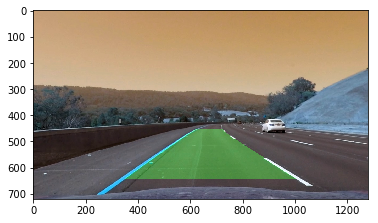

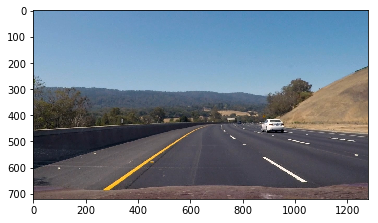

TypeError: src is not a numerical tuple

In [54]:
import os
import matplotlib.image as mpimg

test_dir = "../test_images/"

def processImage(imgPath):
    print("Processing: ", test_dir + imgPath)
#     return perspective_transformed(pipeline(cv2.imread(test_dir + imgPath)))
    return pipeline(cv2.imread(test_dir + imgPath))

def processForLine(imgPath):
    bin_img = processImage(imgPath)

def processTestImages():
    for imgPath in os.listdir(test_dir):
        # Got some .DS_Store files in this folder
        if(not imgPath.endswith("jpg")): continue
        if(imgPath.startswith("op-")): continue
        output = processImage(imgPath)
        mpimg.imsave(test_dir + "op-" + imgPath, output, format='jpg', cmap='gray')
        
# processTestImages()
test_image_path = 'test3.jpg'
op = processImage(test_image_path)
# mpimg.imsave(test_dir + "op-" + test_image_path, op, format='jpg', cmap='gray')
# cv2.imwrite(test_dir + "op-" + test_image_path, op)
imshow(op)
imshow(cv2.imread(test_dir + test_image_path))
imshow(perspective_transformed(cv2.imread(test_dir + test_image_path)))
